# How to Build and Optimize Quantum Approximate Optimization Algorithm (QAOA) Circuits using the SWAP Strategy, a Transpiler Specifically Designed for QAOA.

In this comprehensive guide, we will walk you through the **Quantum Approximate Optimization Algorithm (QAOA)** workflow using **[Qiskit Patterns](https://www.ibm.com/quantum/blog/qiskit-patterns).**
We'll demonstrate the application of these patterns specifically within the domain of **combinatorial optimization** and showcase how the QAOA, a hybrid quantum-classical iterative method, can be employed effectively.

- Step 1: Formulating a combinatorial in terms of finding the ground state of a Hamiltonian. This reformulated problem can be understood by a quantum computer.
- Step 2: Preparation of the necessary quantum circuits optimized for execution on quantum hardware.
- Step 3: Iteratively utilizing Qiskit's `Sampler` primitive to draw samples from the prepared quantum circuits in Step 2. These samples will inform the loss function of our algorithm routine.
- Step 4: Converting the samples from Step 3 into a solution for our combinatorial optimization problem.

Additionally, We will demonstrate how to build and optimize QAOA circuits using the **SWAP strategy**, a specifically designed for QAOA, for a specific instance of the **Max-Cut**.

## Step 1: Mapping the classical problem to a problem that can be understood by a quantum computer.
### Introduction to mapping a classical problem to a Hamiltonian
We are interested in solving a classical combinatorial optimization problem which has the form

\begin{align*}
\min_{x\in \{0, 1\}^n}f(x)
\end{align*}

Here, the vector $x$ are the $n$ decision variables. As you can see, there is nothing relating to quantum computing here yet. We therefore need to reformulate this problem into something that a quantum computer can understand. To be more concrete, we will consider a Quadratic Unconstrained Binary Optimization problem with the form

\begin{align*}
\min_{x\in \{0, 1\}^n}x^T Q x,
\end{align*}

where $Q$ is a $n\times n$ matrix of real numbers. To start, we will convert the binary variables $x_i$ to variables $z_i\in\{-1, 1\}$ by doing

\begin{align*}
x_i = \frac{1-z_i}{2}.
\end{align*}

Here, for example, we see that if $x_i$ is $0$ then $z_i$ is $1$. When we substitute the $x_i$'s for the $z_i$'s in the QUBO above, we obtain the equivalent formulations for our optimization task

\begin{align*}
\min_{x\in\{0,1\}^n} x^TQx\Longleftrightarrow \min_{z\in\{-1,1\}^n}z^TQz + b^Tz
\end{align*}

The details of the computation are shown in Appendix A below. Here, $b$ depends on $Q$. Note that to obtain $z^TQz + b^Tz$ we dropped an irrelevant factor of 1/4 and a constant offset of $n^2$ which do not play a role in the optimization. Now, to obtain a quantum formulation of the problem we promot the $z_i$ variables to a Pauli $Z$ matrix, i.e., a $2\times 2$ matrix of the form

\begin{align*}
Z_i = \begin{pmatrix}1 & 0 \\ 0 & -1\end{pmatrix}.
\end{align*}

When we substitute these matrices in the QUBO above we obtain the following Hamiltonian

\begin{align*}
H_C=\sum_{ij}Q_{ij}Z_iZ_j + \sum_i b_iZ_i.
\end{align*}

We refer to this Hamiltonian as the **cost Hamiltonian**. It has the property that its gound state corresponds to the solution that **minimizes the cost function $f(x)$**.
Therefore, to solve our optimization problem we now need to prepare the ground state of $H_C$ (or a state with a high overlap with it) on the quantum computer. Then, sampling from this state will, with a high probability, yield the solution to $min f(x)$.

### Mapping a Max-Cut problem to a cost function Hamiltonian


The starting point of the workflow is a problem definition, in the form of a **graph** or **cost function hamiltonian**.
In this example, we will use a random 3 regular graph which we want to find the cut that maximizes the number of crossing edges. Having the problem in graph-form will allow us to directly apply SAT-mapping explained later.

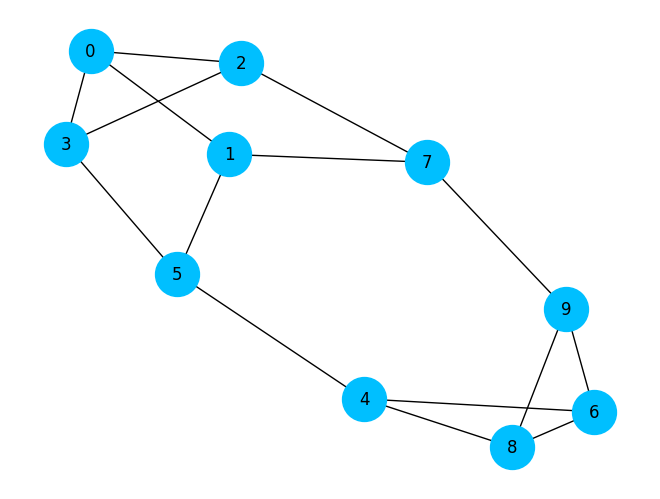

In [1]:
import json
import networkx as nx

seed=100
graph = nx.random_regular_graph(3, 10, seed=seed)
nx.draw(graph, with_labels=True, node_size=1000, node_color="deepskyblue", pos=nx.spring_layout(graph, seed=seed))

This graph has 10 nodes and 15 edges, and it can be encoded in 10 qubits.

In [2]:
num_qubits = len(graph.nodes)
print(num_qubits)

10


The graph utils included in the `qopt-best-practice` library allow you to easily switch between the max-cut graph and cost hamiltonian.

In [3]:
from qopt_best_practices.utils import build_max_cut_paulis, build_max_cut_graph

cost_hamiltonian = build_max_cut_paulis(graph)
print(cost_hamiltonian)

[('IIIIIIIIZZ', 1.0), ('IIIIIIZIIZ', 1.0), ('IIIIIIIZIZ', 1.0), ('IIIIZIIIZI', 1.0), ('IIZIIIIIZI', 1.0), ('IIZIIIIZII', 1.0), ('IIIIIIZZII', 1.0), ('ZIZIIIIIII', 1.0), ('IIIIZZIIII', 1.0), ('IIIIZIZIII', 1.0), ('IZIZIIIIII', 1.0), ('IIIZIZIIII', 1.0), ('ZIIZIIIIII', 1.0), ('ZZIIIIIIII', 1.0), ('IZIIIZIIII', 1.0)]


## Step 2: Building a quantum circuit from the problem and optimizing the quantum circuit for quantum execution.

### 2.1 Building a quantum circuit from the problem for QAOA
The QAOA ansatz is composed of a series of alternating layers of cost hamiltonian unitary and mixer unitary blocks.
Once the cost hamiltonian is constructed, the ansatz for the QAOA algorithm can easily be built by using the `QAOAAnsatz`  circuit from the Qiskit circuit library.

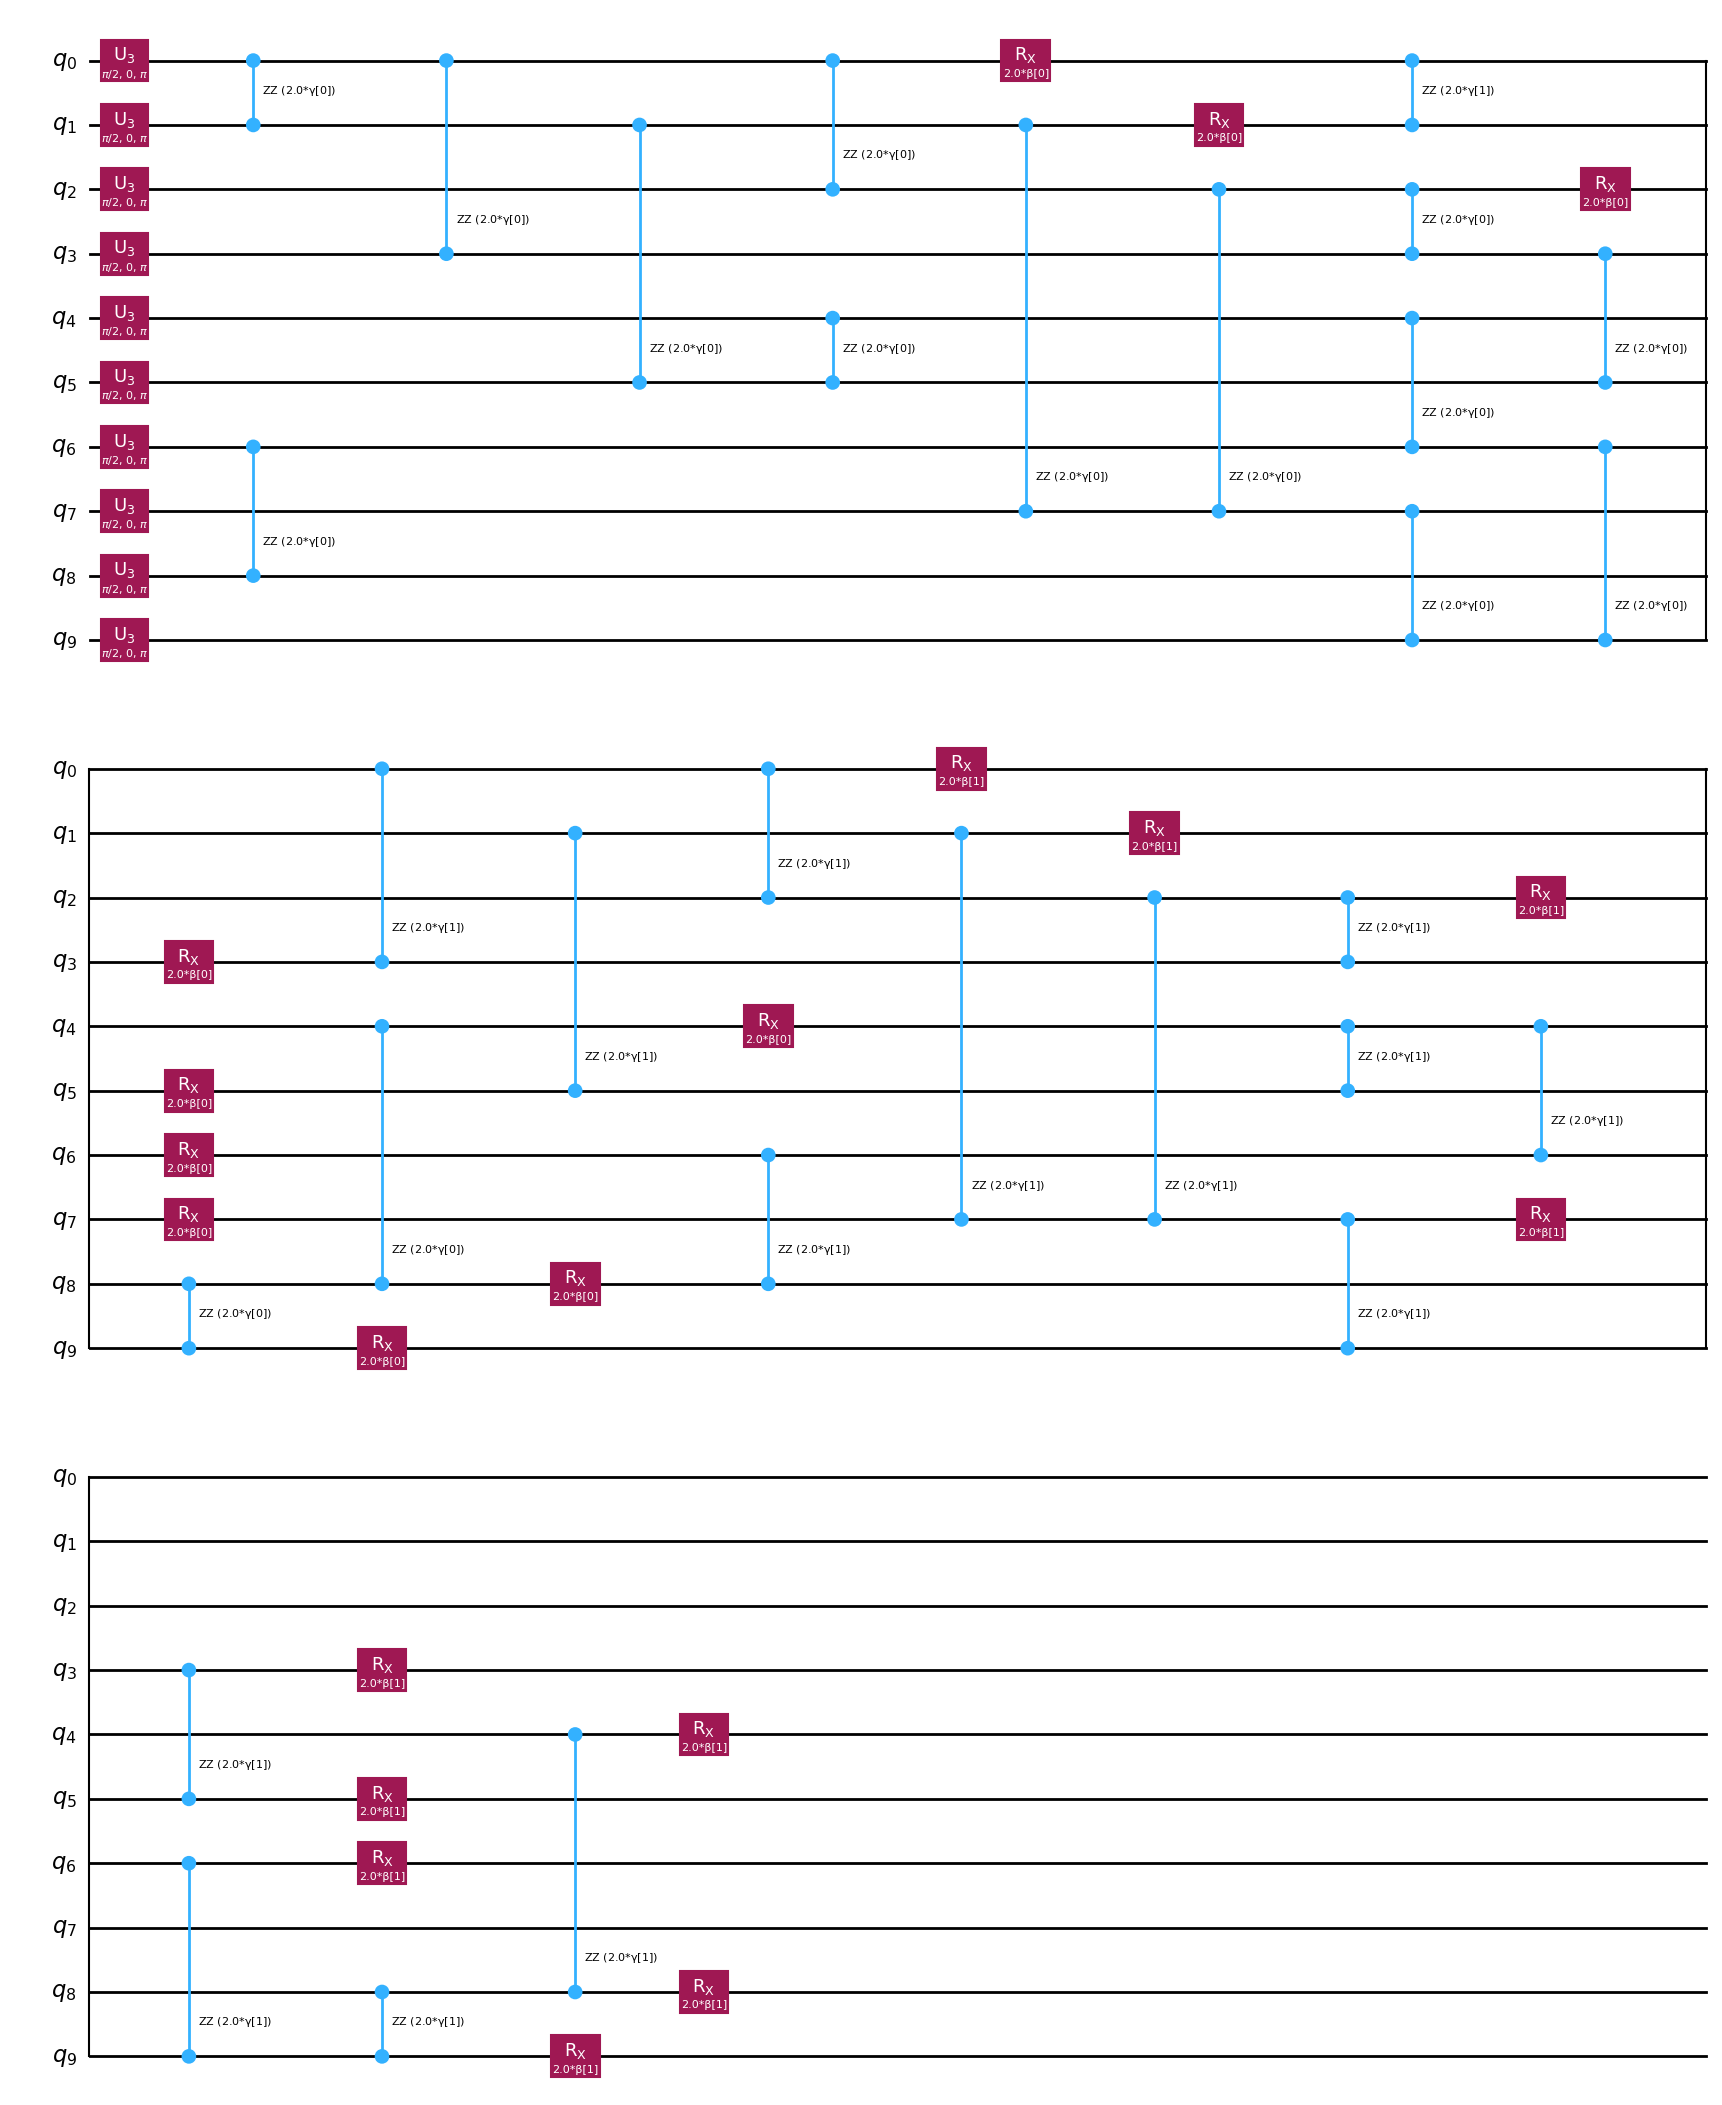

In [4]:
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

cost_operator = SparsePauliOp.from_list(cost_hamiltonian)
ansatz = QAOAAnsatz(
    cost_operator,
    reps=2,
).decompose()
ansatz.decompose(reps=2).draw(output="mpl")

### 2.2 Optimizing the quantum circuit for quantum execution using the SWAP strategy and the SAT mapping
SWAP gate insertion is the technique of choice for most quantum circuits to run on quantum hardware with limited qubit connectivity.  The first couple of steps of the workflow depend on the choice of qubit configuration we want, which will determine the kind of SWAP strategy that will be used, as well as the evaluation criteria for the backend to obtain the best subset of qubits.

In this example, we choose a swap insertion strategy for blocks of commuting two-qubit gates which applies layers of SWAP gates simultaneously executable on the coupling map. This strategy is presented in [Weidenfeller et al.](https://arxiv.org/abs/2202.03459) and exposed as a standardized Qiskit transpiler pass, where we can choose different qubit configurations, in this case, a line.

In [5]:
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import SwapStrategy

swap_strategy = SwapStrategy.from_line([i for i in range(num_qubits)])

#### Remap the graph using a SAT mapper

Even when a circuit consists of commuting gates (this is the case for the QAOA circuit, but also for trotterized simulations of Ising Hamiltonians), finding a good initial mapping is a hard problem. The SAT-based approach presented in [Matsuo et al.](https://arxiv.org/abs/2212.05666) allows to find good initial mappings for circuits with commuting gates, which lead to a reduced number of swap layers.

The [`qopt_best_practices` repository](https://github.com/qiskit-community/qopt-best-practices)  exposes the mapper class from Matsuo et al. (`SATMapper`) and includes the `remap_graph_with_sat` method, enabling the remapping of the problem to a more optimal initial state for a specified swap strategy. This method can significantly reduce the number of swap layers required to execute the circuit."

Map from old to new nodes:  {0: 9, 1: 4, 2: 6, 3: 8, 4: 2, 5: 7, 6: 3, 7: 5, 8: 1, 9: 0}
Min SAT layers: 2


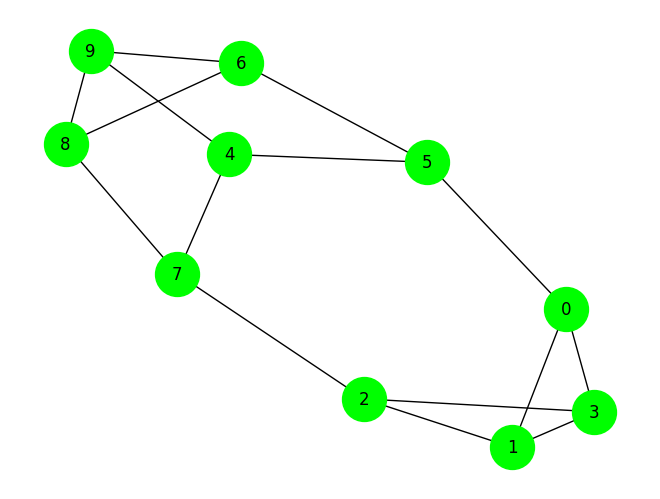

In [6]:
from qopt_best_practices.sat_mapping import SATMapper

sm = SATMapper()
remapped_g, sat_map, min_sat_layers = sm.remap_graph_with_sat(
    graph=graph, swap_strategy=swap_strategy
)

print("Map from old to new nodes: ", sat_map)
print("Min SAT layers:", min_sat_layers)
nx.draw(remapped_g, with_labels=True,node_size=1000, node_color="lime", pos=nx.spring_layout(remapped_g, seed=seed))


#### Construct a cost Hamiltonian from the remapped graph
As explained in Step 1, the repository includes utils to map from a graph to a pauli list for the Max-Cut setting.

In [7]:
remapped_hamiltonian = build_max_cut_paulis(remapped_g)
# define a qiskit SparsePauliOp from the list of paulis
remapped_cost_operator = SparsePauliOp.from_list(remapped_hamiltonian )
print(remapped_cost_operator)

SparsePauliOp(['ZIIIIZIIII', 'ZZIIIIIIII', 'ZIIZIIIIII', 'IIZIIZIIII', 'IIIIZZIIII', 'IIIZZIIIII', 'IZIZIIIIII', 'IIIIZIIIIZ', 'IIZIIIIZII', 'IZZIIIIIII', 'IIIIIIZIZI', 'IIIIIIZZII', 'IIIIIIZIIZ', 'IIIIIIIIZZ', 'IIIIIIIZZI'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


#### Build a QAOA circuit with the SWAP strategy and the SAT mapping
We only want to apply the swap strategies to the cost operator layer, so we will start by creating the isolated block that we will later transform and append to the final QAOA circuit.

For this means, we can use the `QAOAAnsatz` class from Qiskit. We will input an empty circuit to the `initial_state` and `mixer_operator` fields to make sure we are buiding an isolated cost operator layer. 
Check out the corresponding how-to for a deep dive on how [create_qaoa_swap_circuit](https://github.com/qiskit-community/qopt-best-practices/blob/main/how_tos/how_to_build_qaoa_swap_circuit.ipynb) works.dd

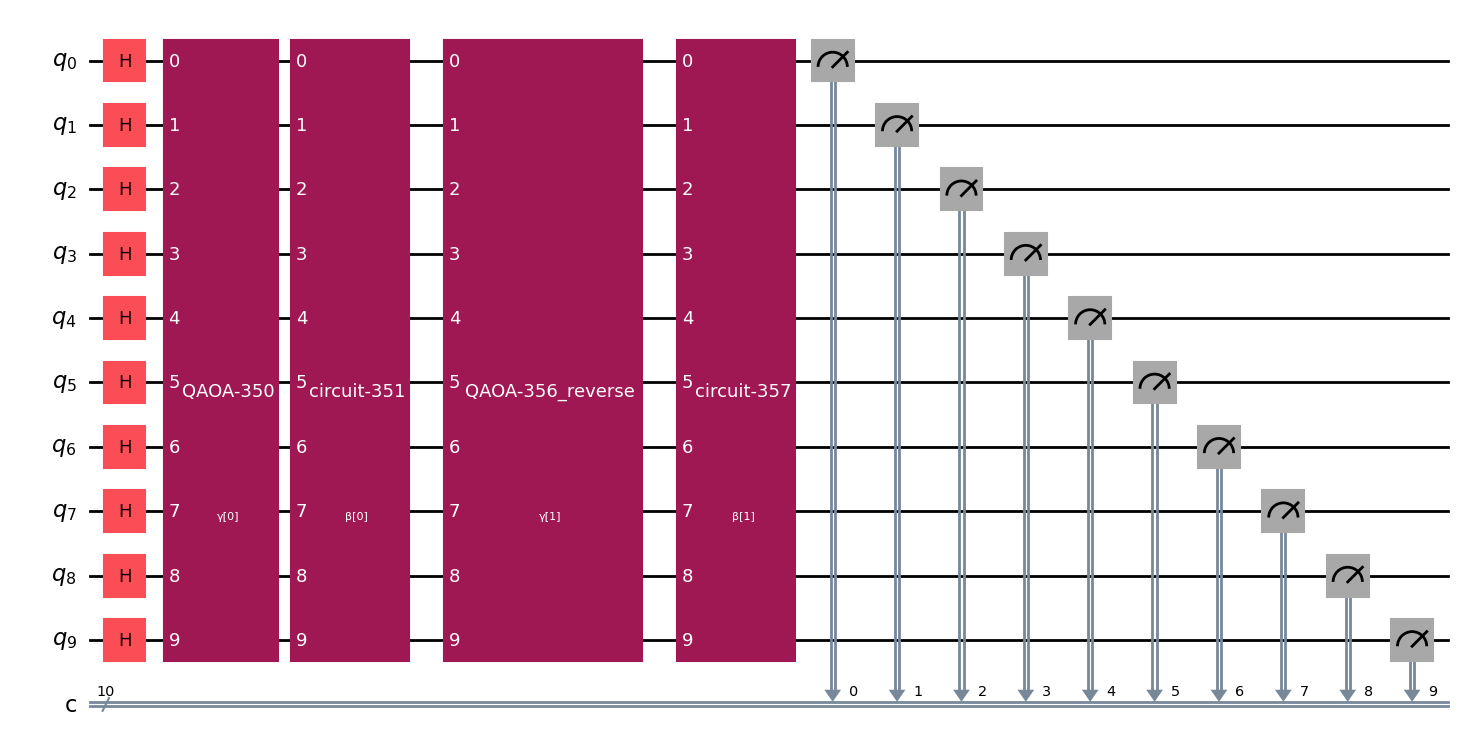

In [8]:
from qopt_best_practices.swap_strategies import create_qaoa_swap_circuit

# We define the edge_coloring map so that RZZGates are positioned next to SWAP gates to exploit CX cancellations
edge_coloring = {
    (idx, idx + 1): (idx + 1) % 2 for idx in range(remapped_cost_operator.num_qubits)
}

qaoa_circ = create_qaoa_swap_circuit(
    remapped_cost_operator, swap_strategy, edge_coloring, qaoa_layers=2
)
qaoa_circ.draw(output="mpl")

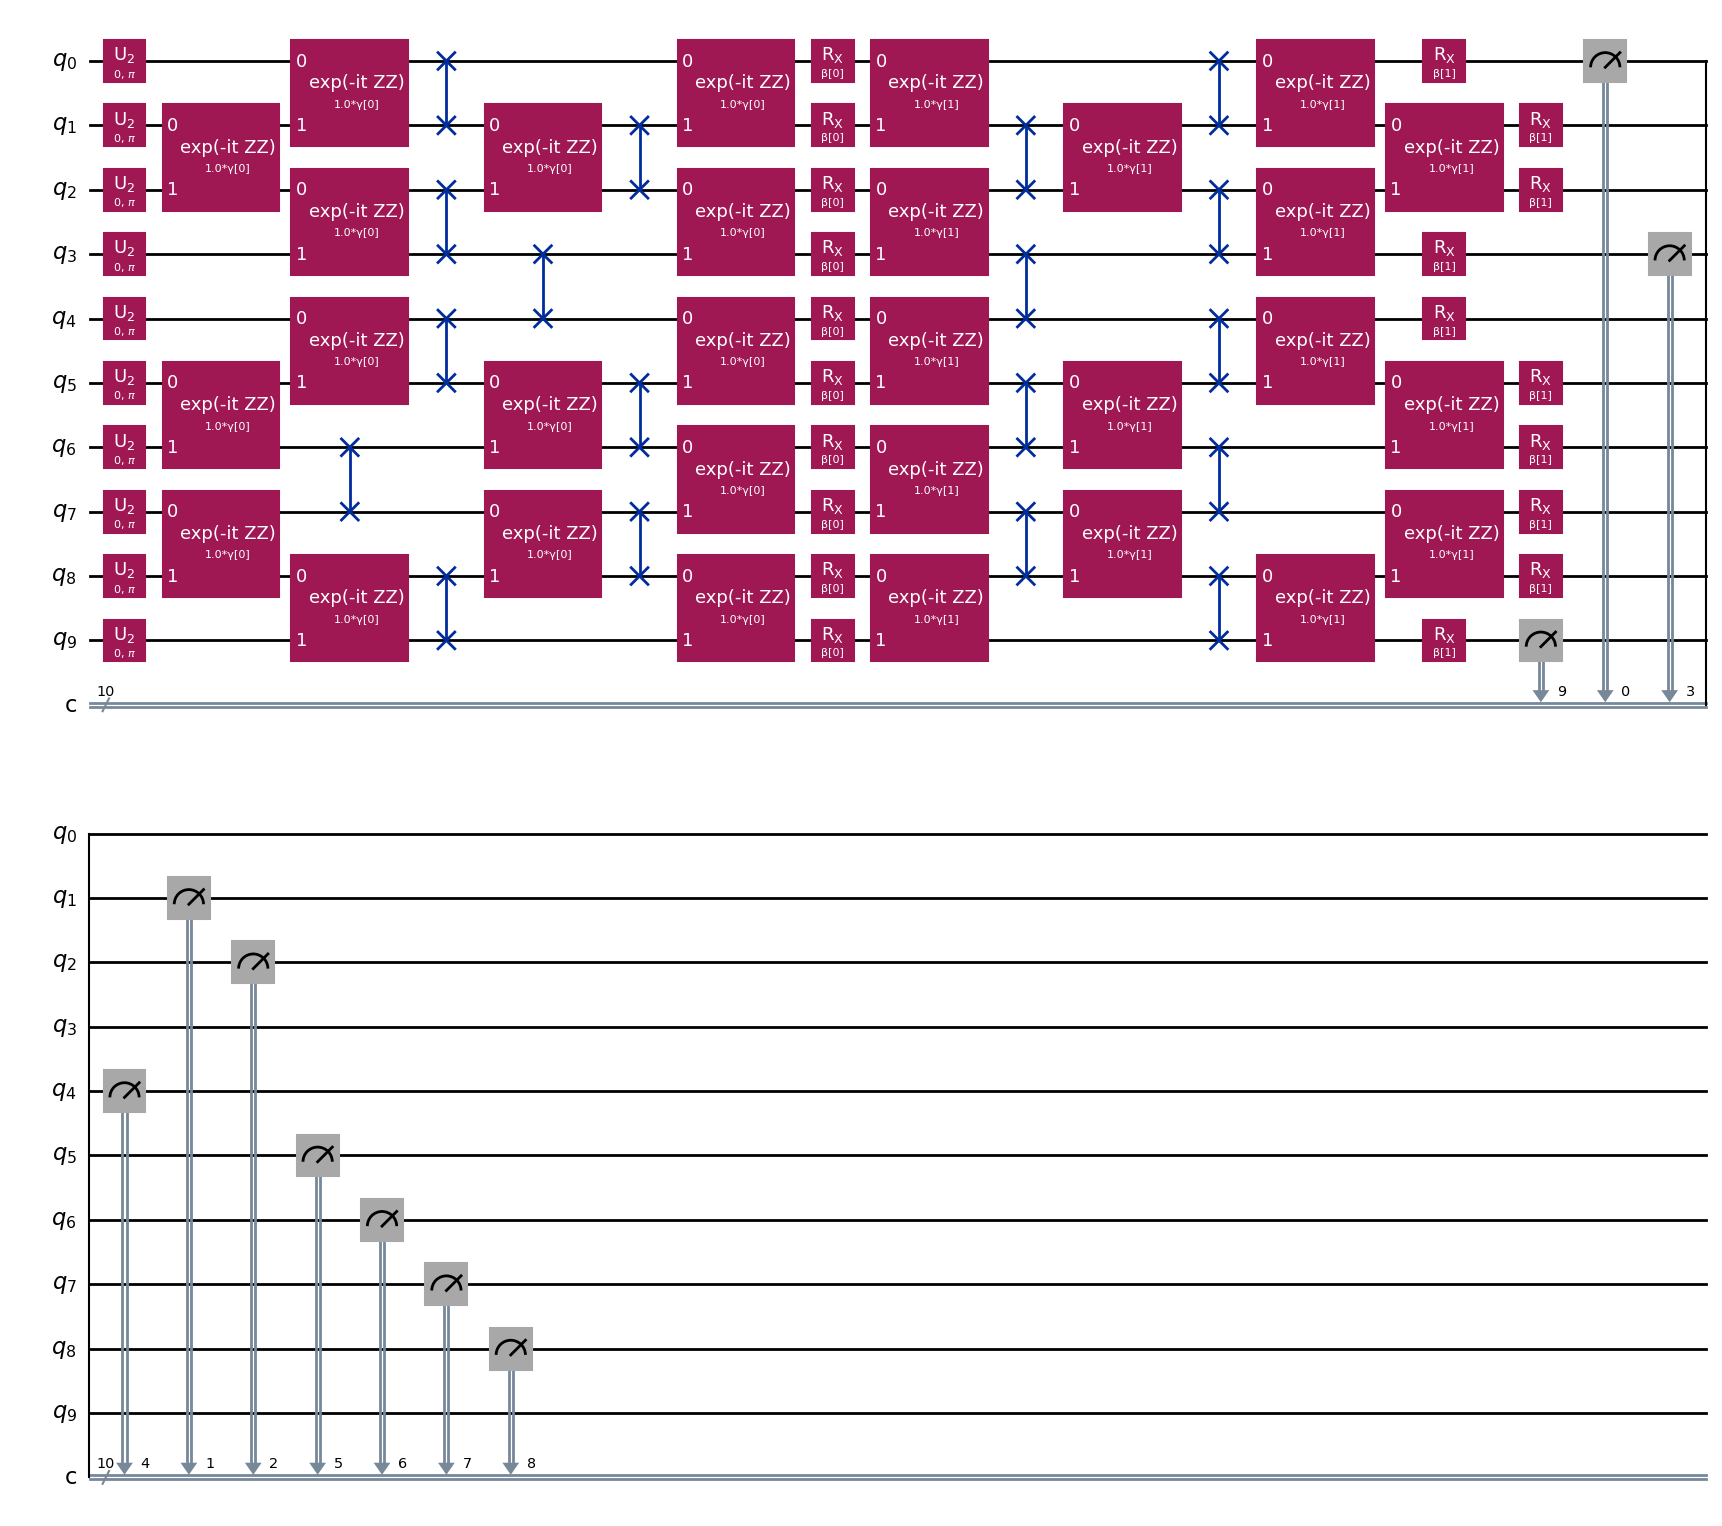

In [9]:
qaoa_circ.decompose().draw(output="mpl")

### 2.3 Evaluate backends to define the best initial layout and transpile the circuit
#### Choose backend
This notebook currently runs on a **simulated fake backend**, using the **BackendSampler** from `qiskit`. To run on **real devices**, and make use of the error supression, mitigation and additional capabilities of **Qiskit Runtime**, you must uncomment the cell that uses the **runtime Sampler.**

It is important to remember to **skip transpilation** during our sampler execution, independently of the primitive being used.

In [10]:
# SIMULATED FAKE BACKEND --> BackendSampler
from qiskit.providers.fake_provider.backends_v1 import Fake20QV1
from qiskit.primitives import BackendSampler

backend = Fake20QV1()
sampler = BackendSampler(backend=backend, skip_transpilation=True)

### Evaluate backends to define the best initial layout

The `BackendEvaluator` util allows you to find the best subset of qubits of a given geometry according to a given metric. By default, it will try to find the **line** (geometry) witht the best **2-qubit gate fidelity** (metric). Check out the how-to on qubit subset finding to learn how to provide customized metric and geometry evaluation callables.

In [11]:
from qopt_best_practices.qubit_selection import BackendEvaluator

path_finder = BackendEvaluator(backend)

# the Backend Evaluator accepts custom subset definitions and metrics,
# but defaults to finding the line with the best fidelity
path, fidelity, num_subsets = path_finder.evaluate(num_qubits)

print("Best path: ", path)
print("Best path fidelity", fidelity)
print("Num. evaluated paths", num_subsets)

Best path:  [14, 9, 8, 7, 12, 11, 16, 17, 18, 19]
Best path fidelity 0.881284126537625
Num. evaluated paths 173


### Transpile the circuit
Define a transpiler initial layout with best path.

In [12]:
from qiskit.transpiler import Layout

initial_layout = Layout.from_intlist(path, qaoa_circ.qregs[0])  # needs qaoa_circ

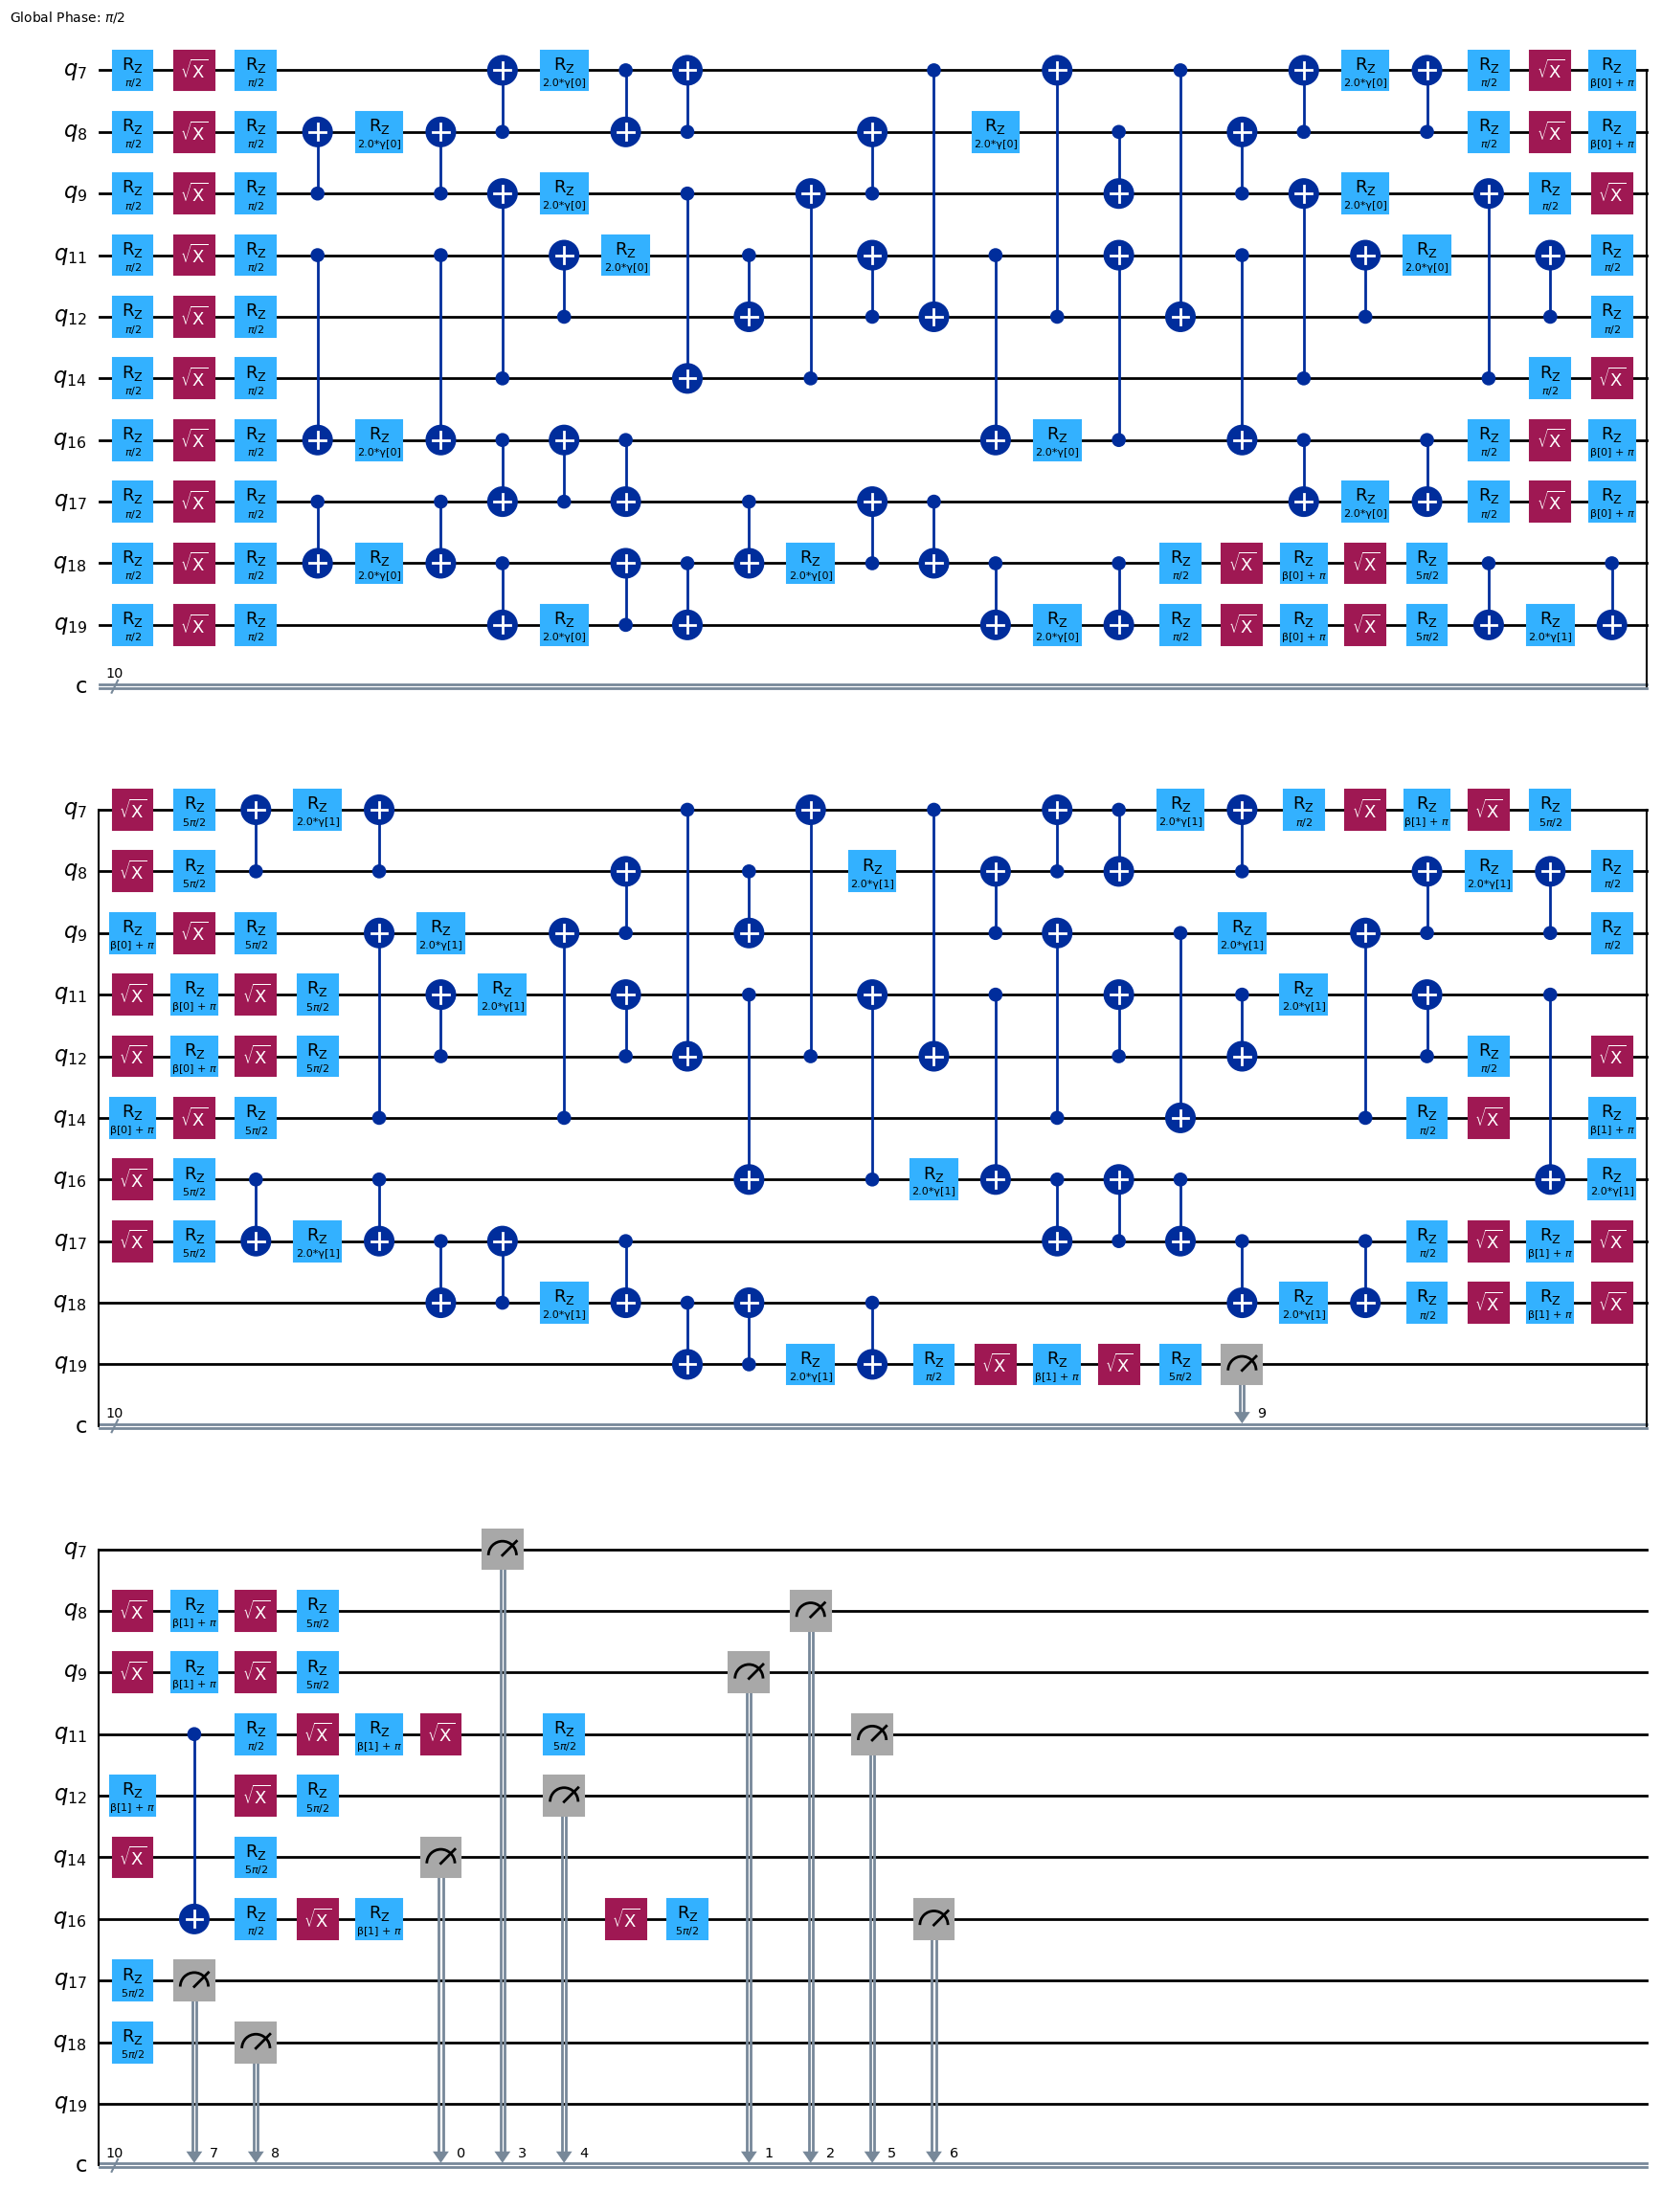

In [13]:
from qiskit.transpiler import CouplingMap, PassManager
from qiskit.transpiler.passes import (
    FullAncillaAllocation,
    EnlargeWithAncilla,
    ApplyLayout,
    SetLayout,
)

from qiskit import transpile

basis_gates = ["rz", "sx", "x", "cx"]

backend_cmap = CouplingMap(backend.configuration().coupling_map)

pass_manager_post = PassManager(
    [
        SetLayout(initial_layout),
        FullAncillaAllocation(backend_cmap),
        EnlargeWithAncilla(),
        ApplyLayout(),
    ]
)

# Map to initial_layout and finally enlarge with ancilla.
qaoa_circ2 = pass_manager_post.run(qaoa_circ)
# Now transpile to sx, rz, x, cx basis
qaoa_circ3 = transpile(qaoa_circ2, basis_gates=basis_gates)
qaoa_circ3.draw(output="mpl", idle_wires=False)

## Step3: Executing the optimized circuit using Qiskit Runtime primitives.
### 3.1 Define a cost function
The QAOA cost function using the Sampler requires the manual computation of the expectation values from the measurement results. For this means, we use the `evaluate_sparse_pauli` helper function.

In [14]:
from qopt_best_practices.cost_function import evaluate_sparse_pauli

def cost_func_sampler(params, ansatz, hamiltonian, sampler):
    job = sampler.run(ansatz, params)
    sampler_result = job.result()
    sampled = sampler_result.quasi_dists[0]
    # a dictionary containing: {state: (measurement probability, value)}
    evaluated = {
        state: (probability, evaluate_sparse_pauli(state, hamiltonian))
        for state, probability in sampled.items()
    }

    result = sum(probability * value for probability, value in evaluated.values())

    return result

### 3.2 Define Initial Point
In this example, we use the TQA initialization technique [(Sack et al. 2021)](https://arxiv.org/abs/2101.05742) to define the initial point of the parameter optimization:

In [15]:
import numpy as np

# TQA initialization parameters
dt = 0.75
p = 2  # 2 qaoa layers
grid = np.arange(1, p + 1) - 0.5
init_params = np.concatenate((1 - grid * dt / p, grid * dt / p))
print(init_params)

[0.8125 0.4375 0.1875 0.5625]


### 3.3 Execute the QAOA circuit using Qiskit Runtime Primitives and iterate over the optimization routine
We can plug our sampler-based cost function into the scipy minimizing routine to find our optimal parameters

In [16]:
from scipy.optimize import minimize

result = minimize(
    cost_func_sampler,
    init_params,
    args=(qaoa_circ3, remapped_cost_operator, sampler),
    method="COBYLA",
)
print(result)

/Users/matsuo/envs/qeet/lib/python3.11/site-packages/qiskit/providers/fake_provider/fake_backend.py:558: RuntimeWarning: Aer not found using BasicAer and no noise
  warnings.warn("Aer not found using BasicAer and no noise", RuntimeWarning)
/Users/matsuo/envs/qeet/lib/python3.11/site-packages/scipy/optimize/_cobyla_py.py:293: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -4.806640625
       x: [ 2.417e+00 -1.872e-02  1.300e+00  6.365e-02]
    nfev: 54
   maxcv: 0.0


## Step 4: Post-processing the results and returning them in classical format.
### 4.1 Sample the best result
We can use the best parameters found by the optimization routine to sample the best result from the QAOA circuit.

In [17]:
def bitfield(n, L):
    result = np.binary_repr(n, width=L)
    return [int(digit) for digit in result]

def sample_most_likely(sample_distribution, num_qubits):
    """Compute the most likely binary string from state vector.
    Args:
        state_vector: quasi-distribution.

    Returns:
        Binary string as an array of ints.
    """
    values = list(sample_distribution.values())
    k = np.argmax(np.abs(values))
    x = bitfield(k, num_qubits)
    x.reverse()
    return np.asarray(x)

In [18]:
qc = qaoa_circ3.assign_parameters(result.x)
samp_dist = sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]

best_result = sample_most_likely(samp_dist, num_qubits)
print(best_result)

[1 1 0 1 1 1 0 0 0 0]


### 4.2 Visualize the solution
We can visualize the solution using the following function.

['deepskyblue', 'deepskyblue', 'salmon', 'deepskyblue', 'deepskyblue', 'deepskyblue', 'salmon', 'salmon', 'salmon', 'salmon']


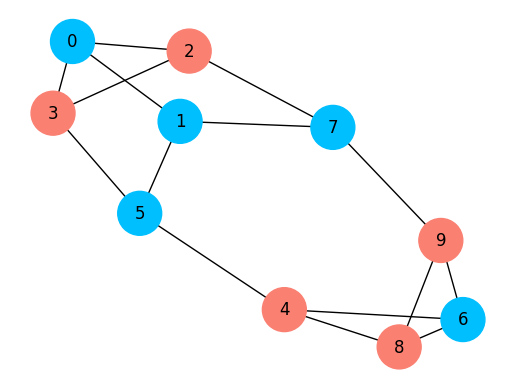

In [19]:
import matplotlib.pyplot as plt

# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ['salmon' if i == 0 else 'deepskyblue' for i in x]
    print(colors)
    # pos, default_axes = nx.spring_layout(G), plt.axes(frameon=True)
    # nx.draw_networkx(G, node_color=colors, node_size=600, pos=pos)
    pos, default_axes = nx.spring_layout(graph, seed=seed), plt.axes(frameon=True)
    nx.draw(graph, with_labels=True, node_size=1000, node_color=colors, pos=pos)

plot_result(graph, best_result)